In [75]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F


## Load Data

In [76]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

In [77]:
df = load_data(path_to_training_tweets)

# df = df.head(100000)

print(df)

            ID  MatchID  PeriodID  EventType      Timestamp  \
0          2_0        2         0          0  1403538600000   
1          2_0        2         0          0  1403538600000   
2          2_0        2         0          0  1403538600000   
3          2_0        2         0          0  1403538600000   
4          2_0        2         0          0  1403538600000   
...        ...      ...       ...        ...            ...   
256440  17_129       17       129          1  1403805600000   
256441  17_129       17       129          1  1403805600000   
256442  17_129       17       129          1  1403805600000   
256443  17_129       17       129          1  1403805600000   
256444  17_129       17       129          1  1403805600000   

                                                    Tweet  
0       RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
1       Visit the #SITEP official web site here http:/...  
2       RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
3  

In [78]:
### Grouping tweets who have same timestamp by concatenating them
MAX_SUBGROUP = 150

# Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
df_bis = df_bis.sample(frac=1).reset_index(drop=True)
print(df_bis)

            ID  MatchID  PeriodID  EventType  \
0        18_59       18        59          1   
1        10_39       10        39          1   
2        4_137        4       137          0   
3        14_83       14        83          0   
4        11_24       11        24          0   
...        ...      ...       ...        ...   
311346   13_73       13        73          1   
311347   0_102        0       102          1   
311348  10_122       10       122          1   
311349   17_63       17        63          1   
311350    7_13        7        13          0   

                                                    Tweet  
0       RT @daveweigel: RT @benpolitico: RT @DavidCorn...  
1       @callmecayce I'm rooting for Germany as well, ...  
2       RT @LineupsApp: It's the #WorldCup of the subs...  
3       Korea is playing so much better than belgium g...  
4       Rooting for Argentina. Not just because I have...  
...                                                   ...  
311

# Preprocessing

In [79]:
def preprocessing(df):
    df["Tweet"] = df["Tweet"].str.lower()
    return df

In [80]:
preprocessing(df_bis)
print(df_bis)

            ID  MatchID  PeriodID  EventType  \
0        18_59       18        59          1   
1        10_39       10        39          1   
2        4_137        4       137          0   
3        14_83       14        83          0   
4        11_24       11        24          0   
...        ...      ...       ...        ...   
311346   13_73       13        73          1   
311347   0_102        0       102          1   
311348  10_122       10       122          1   
311349   17_63       17        63          1   
311350    7_13        7        13          0   

                                                    Tweet  
0       rt @daveweigel: rt @benpolitico: rt @davidcorn...  
1       @callmecayce i'm rooting for germany as well, ...  
2       rt @lineupsapp: it's the #worldcup of the subs...  
3       korea is playing so much better than belgium g...  
4       rooting for argentina. not just because i have...  
...                                                   ...  
311

## Create dictionary from tweets

In [81]:
train, test = train_test_split(df_bis, test_size=0.3, random_state=42)

In [82]:
tokenizer = get_tokenizer("basic_english")
number_of_words_in_dict = 1000

def create_vocab(df, column_name, tokenizer, number_of_words_in_dict):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(number_of_words_in_dict))
    return vocab

vocab = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)
keywords = list(vocab.keys())

['.', 'rt', '!', 'the', "'", ',', 'http', '//t', 'to', 'germany', 'a', 'for', 'in', '#worldcup', 'i', 'is', 's', 'of', 'and', '#ger', 'brazil', 'this', 'if', 'on', '?', 'it', 'we', 'vs', 'argentina', 'you', 'win', 'goal', 'that', 'world', 'france', 'are', '&', '#bra', 't', 'game', 'go', 'cup', '#arg', 'portugal', 'will', 'be', 'algeria', 'follow', 'with', 'they', 'so', 'have', '-', 'ghana', 'but', 'at', 'enter', 'just', 'll', '#fra', 'now', 'give', ')', 'like', '#mex', 'belgium', 'one', 'away', 'can', '#worldcup2014', 'scores', '#ned', 'from', 'all', '(', 'up', 'time', 'not', 'what', 'has', 'my', '#por', 'today', '#alg', 'team', '1-0', 'as', '#usa', '#bel', 'come', 'out', 'score', '#gha', 'nigeria', 'by', 'was', 'goals', 'good', '…', 'match', '@fifaworldcup', 'let', 'half', 'their', 'who', 'his', 'winner', 'm', 'or', '1', '#chi', 'get', '#joinin', 'more', 'he', 'no', 'me', 'still', 'playing', 'pair', 'right', '#aus', 'first', 'final', 'usa', 'do', '#esp', '2', '0', 'going', '#cmr', 'ag

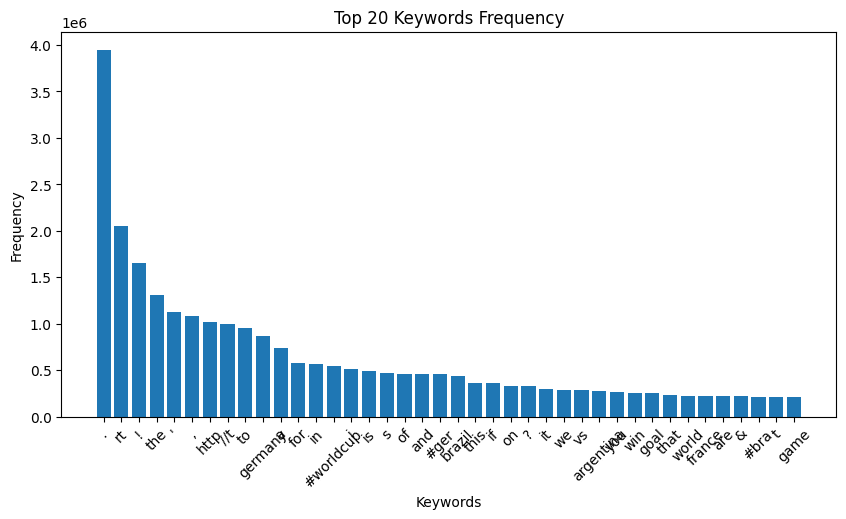

In [83]:
print(keywords)
print(vocab)

# Plot histogram of the top 20 keywords
top_keywords = keywords[:40]
top_counts = [vocab[word] for word in top_keywords]

plt.figure(figsize=(10, 5))
plt.bar(top_keywords, top_counts)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 20 Keywords Frequency')
plt.xticks(rotation=45)
plt.show()

# Embedding

In [84]:
def extract_keyword_frequencies(tweets, keywords):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

In [85]:
print(Counter(tokenizer('Hello, I am a test')))
print(extract_keyword_frequencies(['Hello, I am a test'], ['hello', 'i', 'am']))

Counter({'hello': 1, ',': 1, 'i': 1, 'am': 1, 'a': 1, 'test': 1})
[[0.16666667 0.16666667 0.16666667]]


In [86]:
train_X = extract_keyword_frequencies(train['Tweet'], keywords)

In [87]:
test_X = extract_keyword_frequencies(test['Tweet'], keywords)

# Training

In [88]:
# Standardize the feature matrix
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X) # train_X -> (train_X - mean(train_X)) / std(train_X)
test_X = scaler.transform(test_X)

In [89]:
# Labels
train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
test_y = np.array(test['EventType']).reshape(-1, 1).flatten()

train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

In [90]:
print(f"train_X shape: {train_X.shape}, train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}, test_y shape: {test_y.shape}")

print(f"Number of NaNs in train_X: {np.isnan(train_X).sum()}")
print(f"Number of NaNs in train_y: {np.isnan(train_y).sum()}")


train_X shape: (217945, 1000), train_y shape: torch.Size([217945, 1])
test_X shape: (93406, 1000), test_y shape: torch.Size([93406, 1])
Number of NaNs in train_X: 0
Number of NaNs in train_y: 0


In [91]:
torch.tensor(train_X, dtype=torch.float32)

tensor([[-0.3533,  0.3172, -0.3860,  ..., -0.0984, -0.0855, -0.0960],
        [-0.1823, -0.6833, -0.7368,  ..., -0.0984, -0.0855, -0.0960],
        [ 0.1964, -0.5681,  0.4332,  ..., -0.0984, -0.0855, -0.0960],
        ...,
        [-0.2400, -0.3076,  1.7013,  ..., -0.0984, -0.0855, -0.0960],
        [-0.6296, -0.6658, -0.6363,  ..., -0.0984, -0.0855, -0.0960],
        [ 0.1491, -0.4003,  0.1769,  ..., -0.0984, -0.0855, -0.0960]])

In [92]:
trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

In [93]:
batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [94]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [95]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [96]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

Epoch 1/10, Train Loss: 0.5583, Val Loss: 0.5392, Val Accuracy: 0.7269
Epoch 2/10, Train Loss: 0.5264, Val Loss: 0.5230, Val Accuracy: 0.7363
Epoch 3/10, Train Loss: 0.5075, Val Loss: 0.5158, Val Accuracy: 0.7422
Epoch 4/10, Train Loss: 0.4942, Val Loss: 0.5105, Val Accuracy: 0.7467
Epoch 5/10, Train Loss: 0.4835, Val Loss: 0.5105, Val Accuracy: 0.7457
Epoch 6/10, Train Loss: 0.4754, Val Loss: 0.5102, Val Accuracy: 0.7475
Epoch 7/10, Train Loss: 0.4677, Val Loss: 0.5092, Val Accuracy: 0.7473
Epoch 8/10, Train Loss: 0.4626, Val Loss: 0.5087, Val Accuracy: 0.7502
Epoch 9/10, Train Loss: 0.4567, Val Loss: 0.5088, Val Accuracy: 0.7467
Epoch 10/10, Train Loss: 0.4525, Val Loss: 0.5091, Val Accuracy: 0.7491


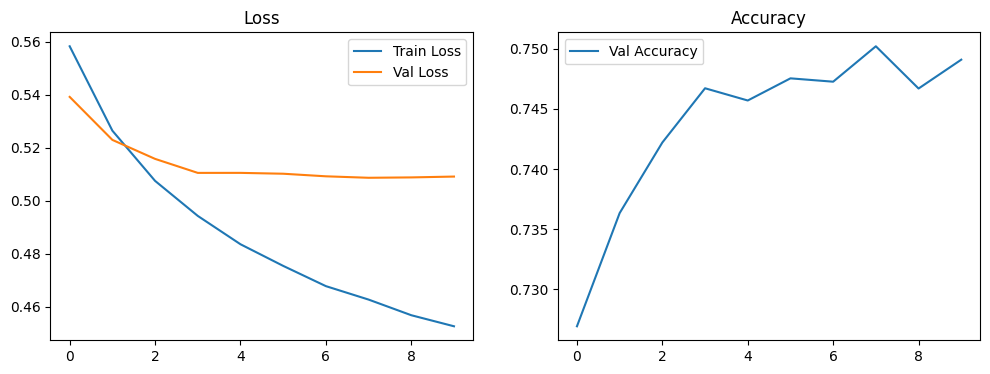

In [97]:
# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

# Plot training history
plot_history(history)
